# Example

This example demonstrates the whole process from initial atomic structure to training, evaluation and prediction. It includes:


1. Read input atomic structures (saved as extxyz files) and create descriptors and their derivatives.

2. Read inputs and outputs into a Data object.

3. Create tensorflow dataset for training.

4. Train the potential and apply it for prediction.

5. Save the trained model and then load it for retraining or prediction.


The code has been tested on Tensorflow 2.5 and 2.6.

In [1]:
import atomdnn

# 'float64' is used for reading data and train by default
atomdnn.data_type = 'float64'

# force and stress are evaluated by default, 
# if one only need to compute potential energy, then set compute_force to false
atomdnn.compute_force = True

# default value is for converting ev/A^3 to GPa
# note that: the predicted positive stress means tension and negative stress means compression
stress_unit_convert = 160.2176 

import numpy as np
import pickle
import tensorflow as tf
from atomdnn import data
from atomdnn.data import Data
from atomdnn.data import *
from atomdnn.descriptor import *
from atomdnn import network
from atomdnn.network import Network

## Create descriptors

**Read input atomic structures (saved as extxyz files) and create descriptors and their derivatives**


In [2]:
descriptor = {'name': 'acsf', 
              'cutoff': 6.5,
              'etaG2':[0.01,0.1,1,5,10], 
              'etaG4': [0.01], 
              'zeta': [0.08,1.0,10.0,100.0],
              'lambda': [1.0, -1.0]}


# define lammps excutable (serial or mpi) 
# LAMMPS has to be compiled with the added compute and dump_local subrutines (inside atomdnn/lammps)
lmpexe = 'lmp_serial' 
#lmpexe = 'mpirun -np 2 lmp_mpi'  # can be mpi version


elements = ['C']
xyzfile_path='extxyz'
xyzfile_name = 'example_extxyz.*' # a serials of files like example_extxyz.1, example_extxyz.2, ...example_extxyz.n
descriptors_path = './descriptors'

descriptor_filename = 'dump_fp.*' # a serials of dump_fp.* files will be created
der_filename ='dump_der.*'

print('total number of fingerprints = %i'%get_num_fingerprints(descriptor,elements))

total number of fingerprints = 14


In [3]:
# this will create a serials of files for descriptors and their derivatives inside descriptors_path
create_descriptors(lmpexe,
                   elements,
                   xyzfile_path, 
                   xyzfile_name, 
                   descriptors_path, 
                   descriptor, 
                   descriptor_filename, 
                   der_filename)

Start creating fingerprints and derivatives for 50 files ...
  so far finished for 10 images ...
  so far finished for 20 images ...
  so far finished for 30 images ...
  so far finished for 40 images ...
  so far finished for 50 images ...
Finish creating descriptors and derivatives for total 50 images.
It took 10.55 seconds.


## Read inputs&outputs

**Read inputs and outputs into a Data object** 

In [4]:
# create a Data object
mydata = Data()

In [5]:
# read inputs: descriptors and their derivatives
mydata.read_inputdata(descriptors_path, descriptor_filename, der_filename)

Start reading fingerprints from 'dump_fp.*' for total 50 files ...
  so far read 50 images ...
  Finish reading fingerprints from total 50 images.


Start reading derivatives from 'dump_der.*' for total 50 files ...
  This may take a while for large data set ...
  so far read 50 images ...
  Finish reading dGdr derivatives from total 50 images.

  It took 1.02 seconds to read the derivatives data.

---------- input dataset information ----------
total images = 50
max number of atoms = 4
number of fingerprints = 14
number of atom types = 1
max number of derivative pairs = 200
------------------------------------------------


In [6]:
# read outputs: potential energy, force and stress from extxyz files
mydata.read_outputdata(xyzfile_path, xyzfile_name)

Reading outputs from extxyz files ...
  so far read 50 images ...
  Finish reading outputs from total 50 images.


---------- output dataset information ------------
total images = 50
max number of atoms = 4
read_force = True
read_stress = True
---------------------------------------------------


## Create TFdataset

**Create tensorflow dataset for training**

In [7]:
# convert data to tensors
mydata.convert_data_to_tensor()

Conversion may take a while for large datasets...
It took 0.0046 second.


In [8]:
# create tensorflow dataset
tf_dataset = tf.data.Dataset.from_tensor_slices((mydata.input_dict,mydata.output_dict))

In [9]:
dataset_path = './example_tfdataset'

# save the dataset
tf.data.experimental.save(tf_dataset, dataset_path)

# save the element_spec to disk for future loading, this is only needed for tensorflow lower than 2.6
with open(dataset_path + '/element_spec', 'wb') as out_: 
    pickle.dump(tf_dataset.element_spec, out_)

**Note: The above three steps just need to be done once for one data set, the training only uses the saved tensorflow dataset.**

## Training

**Load the dataset and train the model**

In [10]:
# load tensorflow dataset, for Tensorflow version lower than 2.6, need to specify element_spec.

with open(dataset_path + '/element_spec', 'rb') as in_:
    element_spec = pickle.load(in_)

dataset = tf.data.experimental.load(dataset_path,element_spec=element_spec)

In [11]:
# split the data to training, validation and testing sets

train_dataset, val_dataset, test_dataset = split_dataset(dataset,0.7,0.2,0.1,shuffle=True)

Traning data: 35 images
Validation data: 10 images
Test data: 5 images


In [12]:
# Build the network
# See section 'Training' for detailed description on Network object.

act_fun = 'relu' # activation function
nfp = get_num_fingerprints(descriptor,elements) # number of fingerprints (or descriptors) from dataset
arch = [10,10] # NN layers

model = Network(elements, nfp, arch, act_fun)

In [13]:
# Train the model 

opt = 'Adam' # optimizer
loss_fun = 'mae' # loss function
scaling = 'std' # scaling the traning data with standardization
lr = 0.01 # learning rate
loss_weights = {'pe' : 1, 'force' : 1, 'stress': 0.1} # the weights in loss function

model.train(train_dataset,val_dataset,
            optimizer=opt, 
            loss_fun = loss_fun, 
            batch_size=30, 
            lr=lr, 
            epochs=50, 
            scaling=scaling, 
            loss_weights=loss_weights, 
            compute_all_loss=True, 
            shuffle=True, 
            append_loss=True)

Forces are used for training.
Stresses are used for training.
Scaling factors are computed using training dataset.
Training dataset are standardized.
Validation dataset are standardized.
Training dataset will be shuffled during training.

===> Epoch 1/50 - 0.287s/epoch
     training_loss    - pe_loss: 31.190 - force_loss: 356.384 - stress_loss: 39990.078 - total_loss: 4386.582
     validation_loss  - pe_loss: 32.375 - force_loss: 327.956 - stress_loss: 38602.905 - total_loss: 4220.621

===> Epoch 2/50 - 0.255s/epoch
     training_loss    - pe_loss: 29.309 - force_loss: 331.239 - stress_loss: 33570.114 - total_loss: 3717.558
     validation_loss  - pe_loss: 28.926 - force_loss: 277.891 - stress_loss: 31481.089 - total_loss: 3454.926

===> Epoch 3/50 - 0.243s/epoch
     training_loss    - pe_loss: 19.546 - force_loss: 299.680 - stress_loss: 23171.993 - total_loss: 2636.426
     validation_loss  - pe_loss: 26.623 - force_loss: 241.708 - stress_loss: 25293.141 - total_loss: 2797.644

===> 


===> Epoch 33/50 - 0.246s/epoch
     training_loss    - pe_loss: 9.099 - force_loss: 184.592 - stress_loss: 5416.165 - total_loss: 735.307
     validation_loss  - pe_loss: 9.814 - force_loss: 150.473 - stress_loss: 6569.242 - total_loss: 817.212

===> Epoch 34/50 - 0.228s/epoch
     training_loss    - pe_loss: 8.762 - force_loss: 160.241 - stress_loss: 5852.148 - total_loss: 754.218
     validation_loss  - pe_loss: 9.374 - force_loss: 145.594 - stress_loss: 6108.906 - total_loss: 765.858

===> Epoch 35/50 - 0.240s/epoch
     training_loss    - pe_loss: 12.406 - force_loss: 159.299 - stress_loss: 8944.486 - total_loss: 1066.153
     validation_loss  - pe_loss: 8.900 - force_loss: 141.091 - stress_loss: 5858.747 - total_loss: 735.865

===> Epoch 36/50 - 0.213s/epoch
     training_loss    - pe_loss: 9.840 - force_loss: 149.606 - stress_loss: 7718.608 - total_loss: 931.307
     validation_loss  - pe_loss: 8.535 - force_loss: 131.647 - stress_loss: 5924.420 - total_loss: 732.624

===> Epoc

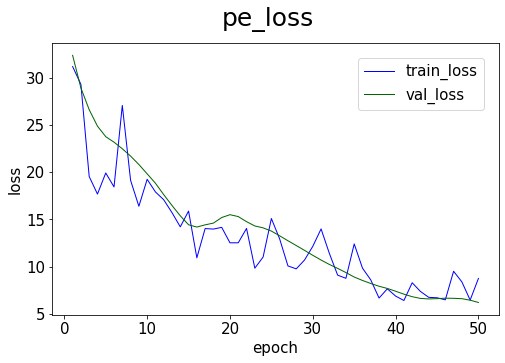

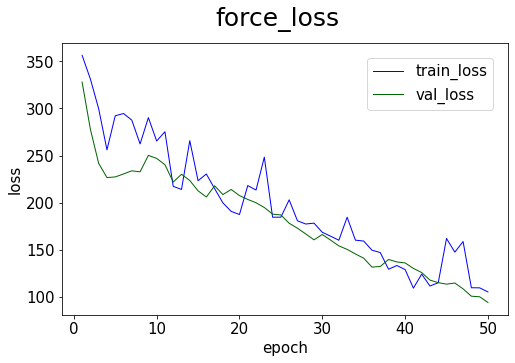

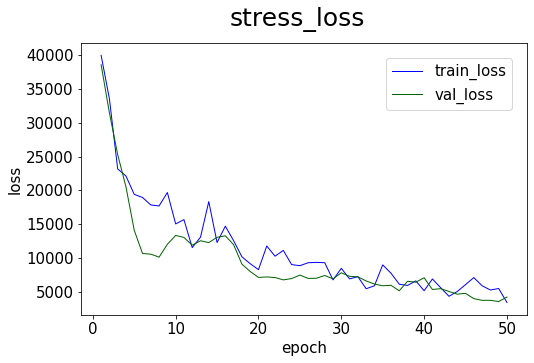

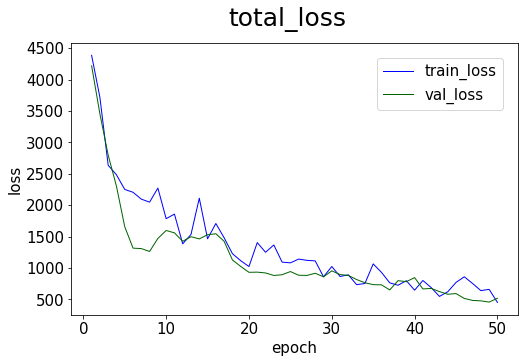

In [14]:
# plot the training loss

model.plot_loss(start_epoch=1)

In [15]:
# Evaluate using the first 5 data in test dataset

model.evaluate(test_dataset.take(5),return_prediction=False)

Evaluation loss is:
        pe_loss:       8.3364e+00
     force_loss:       9.8733e+01
    stress_loss:       4.5703e+03
     total_loss:       5.6410e+02
The total loss is computed using the loss weights - pe: 1.00 - force: 1.00 - stress: 0.10


In [16]:
# prediction using the first 5 data in test dataset

input_dict = get_input_dict(dataset.take(5))
model.predict(input_dict)

{'pe': array([  4.98966932, -15.53297727, -21.9046552 , -29.27170519,
        -26.450315  ]),
 'force': array([[[ -75.06978466, -172.92211148,  229.67395629],
         [  74.41928761,  -38.89317527, -129.60283767],
         [ 291.48027163,   79.89212325,  108.91411508],
         [-290.82977488,  131.92316363, -208.98523383]],
 
        [[  -1.12284797,  -46.38003397,  -56.78587395],
         [  37.89161011,   60.28494093,  -68.44166021],
         [ -45.4923701 ,  -90.1904247 ,  132.87016702],
         [   8.7236079 ,   76.2855178 ,   -7.64263283]],
 
        [[-106.47649583,  -12.34103851,  377.1129094 ],
         [  80.46425249,  217.20247428, -316.56428174],
         [ 150.11888887, -261.81965841,  112.99040383],
         [-124.10664501,   56.95822197, -173.53903144]],
 
        [[-263.93606985,   84.63016038, -102.77425547],
         [-179.60252309,   15.28498485,  -69.12516193],
         [ 317.26096084,  -41.53343411,  -15.18248703],
         [ 126.27763224,  -58.38171139,  187.081

## Save/load model

**save the trained model**

In [17]:
# we re-write the descriptor here to empasize that it should be the same one defined above
descriptor = {'name': 'acsf', 
              'cutoff': 6.5,
              'etaG2':[0.01,0.05,0.1,0.5,1,5,10], 
              'etaG4': [0.01], 
              'zeta': [0.08,0.2,1.0,5.0,10.0,50.0,100.0],
              'lambda': [1.0, -1.0]}

save_dir = 'example.tfdnn'
network.save(model,save_dir,descriptor=descriptor)

INFO:tensorflow:Assets written to: example.tfdnn/assets
Network signatures and descriptor are written to example.tfdnn/parameters for LAMMPS simulation.


**Load the trained model for continuous training and prediction**

In [18]:
imported_model = network.load(save_dir)

# Re-train the model 
loss_weights = {'pe' : 1, 'force' : 1, 'stress': 0.1}

opt = 'Adam'
loss_fun = 'mae'
scaling = 'std'

model.train(train_dataset, val_dataset, 
            optimizer=opt, 
            loss_fun = loss_fun, 
            batch_size=30, 
            lr=0.02, 
            epochs=50, 
            scaling=scaling, 
            loss_weights=loss_weights, 
            compute_all_loss=True, 
            shuffle=True, 
            append_loss=True)

Network has been inflated! self.built: True
Forces are used for training.
Stresses are used for training.
Scaling factors are computed using training dataset.
Training dataset are standardized.
Validation dataset are standardized.
Training dataset will be shuffled during training.

===> Epoch 1/50 - 0.286s/epoch
     training_loss    - pe_loss: 6.225 - force_loss: 107.097 - stress_loss: 5896.093 - total_loss: 702.930
     validation_loss  - pe_loss: 5.153 - force_loss: 81.355 - stress_loss: 3708.718 - total_loss: 457.380

===> Epoch 2/50 - 0.291s/epoch
     training_loss    - pe_loss: 6.683 - force_loss: 85.014 - stress_loss: 3550.454 - total_loss: 446.742
     validation_loss  - pe_loss: 6.016 - force_loss: 72.757 - stress_loss: 3547.104 - total_loss: 433.484

===> Epoch 3/50 - 0.208s/epoch
     training_loss    - pe_loss: 4.510 - force_loss: 71.721 - stress_loss: 3633.668 - total_loss: 439.598
     validation_loss  - pe_loss: 6.587 - force_loss: 69.578 - stress_loss: 3321.606 - total


===> Epoch 34/50 - 0.234s/epoch
     training_loss    - pe_loss: 1.158 - force_loss: 18.625 - stress_loss: 217.164 - total_loss: 41.499
     validation_loss  - pe_loss: 1.145 - force_loss: 15.217 - stress_loss: 211.943 - total_loss: 37.557

===> Epoch 35/50 - 0.262s/epoch
     training_loss    - pe_loss: 0.966 - force_loss: 16.210 - stress_loss: 171.115 - total_loss: 34.287
     validation_loss  - pe_loss: 1.496 - force_loss: 16.229 - stress_loss: 217.624 - total_loss: 39.487

===> Epoch 36/50 - 0.207s/epoch
     training_loss    - pe_loss: 1.585 - force_loss: 15.893 - stress_loss: 223.773 - total_loss: 39.856
     validation_loss  - pe_loss: 1.950 - force_loss: 15.536 - stress_loss: 227.235 - total_loss: 40.210

===> Epoch 37/50 - 0.226s/epoch
     training_loss    - pe_loss: 2.034 - force_loss: 15.639 - stress_loss: 162.887 - total_loss: 33.961
     validation_loss  - pe_loss: 1.884 - force_loss: 14.791 - stress_loss: 193.579 - total_loss: 36.033

===> Epoch 38/50 - 0.251s/epoch
   

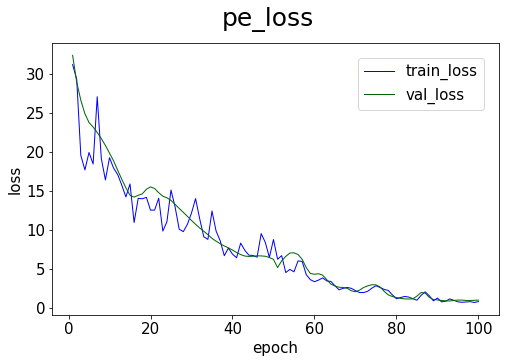

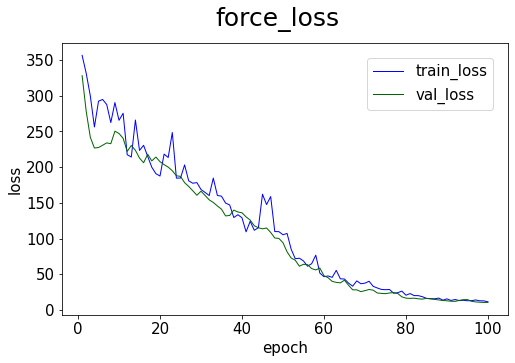

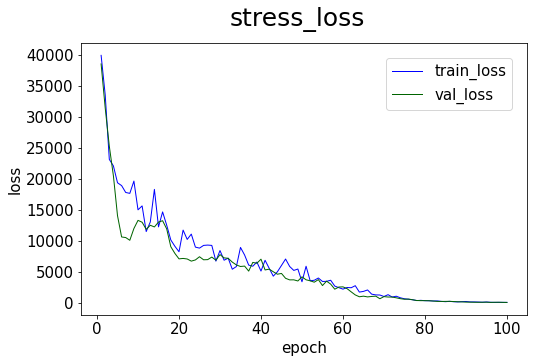

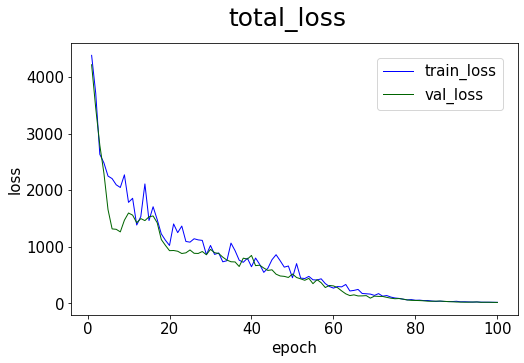

In [19]:
model.plot_loss(start_epoch=1)

In [20]:
imported_model.evaluate(test_dataset.take(5),return_prediction=False)

Evaluation loss is:
        pe_loss:       8.3364e+00
     force_loss:       9.8733e+01
    stress_loss:       4.5703e+03
     total_loss:       5.6410e+02
The total loss is computed using the loss weights - pe: 1.00 - force: 1.00 - stress: 0.10


In [21]:
input_dict = get_input_dict(test_dataset.take(5))
imported_model.predict(input_dict)

{'pe': array([-35.19343363, -30.5018231 , -13.10211931, -40.24163573,
        -34.76370812]),
 'force': array([[[  62.99615578,  -13.02417413,   35.15568535],
         [ 125.17564353,   56.29076835,    4.00421797],
         [-120.00388   ,  -31.82880756,    4.69251285],
         [ -68.16791941,  -11.43778665,  -43.85241614]],
 
        [[ -10.02454801,  -75.68597036,  -84.857218  ],
         [  76.18432679,   28.68981993,  116.42437951],
         [ 104.90041358,   37.58853954,  216.42067892],
         [-171.06019292,    9.40761135, -247.98784042]],
 
        [[-187.60105157,   72.76025473,   95.32019806],
         [ 115.33638883,  -71.88966868,  -41.80044277],
         [  69.78280937,  152.38949361,   73.49249946],
         [   2.48185339, -153.26007932, -127.01225473]],
 
        [[ -78.6992566 , -152.26434996,  -34.44163215],
         [ 217.72729506,   42.42075491,  330.17770106],
         [  61.01884481, -136.88389852,   -9.8914536 ],
         [-200.04688344,  246.72749333, -285.844